<h1> Project Final Report</h1>
<h3>Group 004_28 </h3>

<h2>Introduction</h2>

<h3>Background</h3>

The Pacific Laboratory for Artificial Intelligence (PLAI) is a research group in computer science at UBC. They have a Minecraft server, PLAIcraft, where they record players' actions as they navigate the virtual world. The research group would like to target their PLAIcraft recruitment efforts, and ensure they have enough resources to handle the number of players they attract. 

This report explores the question "*What *kinds* of players are most likely to contribute a large amount of data?*"</br> 
Specifically, our group is interested in learning how a **player's age** might be related to **how much data they contribute** (i.e. total played hours). 

<h3>Summary of Datasets</h3>
The provided data consists of two csv files, 'Players' (9 variables, 196 observations), and 'Sessions' (5 variables, 1535 observations). Both are summarized below.

<h4>Players</h4> 

<div style="display: inline-block">  
    
| Variable         | Type of Data*         | Interpretation | Options / Other Notes|
| ------------------- | --------------------- | -------------------- | ------- |
| *experience*          | categorial - ordinal  | experience level of player, selected by player | *Beginner, Amateur, Regular, Pro, Veteran* |
| *hashedEmail*         | character             | email address of player in hashed form | e.g. *f6daba428a5e19a3d47574858c135*... |
| *name* | character | pseudonym chosen by player | Many options were provided to players. Given this, it makes sense to treat this as character, not factor. |
| *gender* | categorial | gender of player, selected by the player | *Male, Female, Non-binary, Agender, Two-Spirited, Other, Prefer not to say* |
| *played_hours* | double | number of hours player has played on server, to one decimal place | e.g. *22.5* |
| *age* | double | age of player, selected by the player | e.g. *30* |
| *subscribe* | logical | a boolean indicating whether player subscribed to PlaiCraft  updates | *TRUE, FALSE* | 
| *individualId* | double | unique number identifying player | Note that this column contains only *N/A*. |
| *organizationName* | character | organization as indicated by player | Note that this column contains only *N/A*. |
</div>

\* Represents most appropriate type, not the type initially assigned by R.
<br />

<h4>Sessions</h4> 

<div style="display: inline-block"> 
    
| Variable                 | Type of Data* | Interpretation                           | Other Notes |
| ------------------------ | ------------- | ---------------------------------------- | ----------- |
| *hashed_Email*           | character | email address of player in hashed form | e.g. *50499be23603422e6a0ee97...* |
| *start_time*             | character | date, time Plaicraft session began | e.g. *30/06/2024 18:12* |
| *end_time*               | character | date, time  Plaicraft session finished | e.g. *30/06/2024 18:24* |
| *original_start_time*    | double        | UNIX timestamp of session start | e.g. *1.71977E+12* |
| *original_end_time*      | double        | UNIX timestamp of session end | e.g. *1.71977E+12* |

</div>

<h2>Method & Results</h2>

<h3>Loading Data</h3>

First, we load the necessary libraries, then read the datasets from their URLs.

In [46]:
library(tidyverse)
library(tidymodels)
library(repr)

players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<h3>Wrangling & Cleaning Data</h3>

Then, we get rid of the `individualId` and the `organizationName` columns in the `players` data frame, since all values are N/A (and therefore useless).

In [48]:
players <- players |>
select(-individualId, -organizationName)

Next, we redefine the `experience` and `gender` columns as **factors** using the `as_factor` function, so that these variables will be treated as categorical.

In [50]:
players <- players |>
mutate(experience = as_factor(experience)) |>
mutate(gender = as_factor(gender))

players

We also create a new `sessions_sum` data frame using `group_by` and `summarise`.

This shows us the number of sessions per hashed email, i.e. the number of sessions per individual. This data is in a form more related to our question.

In [7]:
sessions_sum <- sessions |>
group_by(hashedEmail) |>
summarise(number_of_sessions = n())

sessions_sum

hashedEmail,number_of_sessions
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


Next, we bind this refined sessions data frame with the `players` data frame, using `left_join`. This brings together all required variables.  This way, we can use just one data frame for all subsequent analysis steps.

In [51]:
data <- left_join(players, sessions_sum)

data

Joining with `by = join_by(hashedEmail)`


experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,1


<h3>Data Analysis</h3>

As mentioned in the introduction, we would like to explore the relationship between **age** and **total playtime**. 

To do this, we will create a model that predicts `age` using `played_hours`. If its accurate - in other words, if the $RMSE$ and $RMSPE$ are low enough- we conclude that player's age can help us to determine played hours.

Since both are numerical variables, this calls for **linear regression**! 

We will start by splitting the data into training and testing sets, in a 70:30 ratio.

In [14]:
data_split <- initial_split(data, prop = 0.7, strata = age)
data_training <- training(data_split)
data_testing <- testing(data_split)

Next, before creating the algorithm, let's make a **scatterplot** using `ggplot` through these variables to actually see if there seems to be a relationship between them.

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 15
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

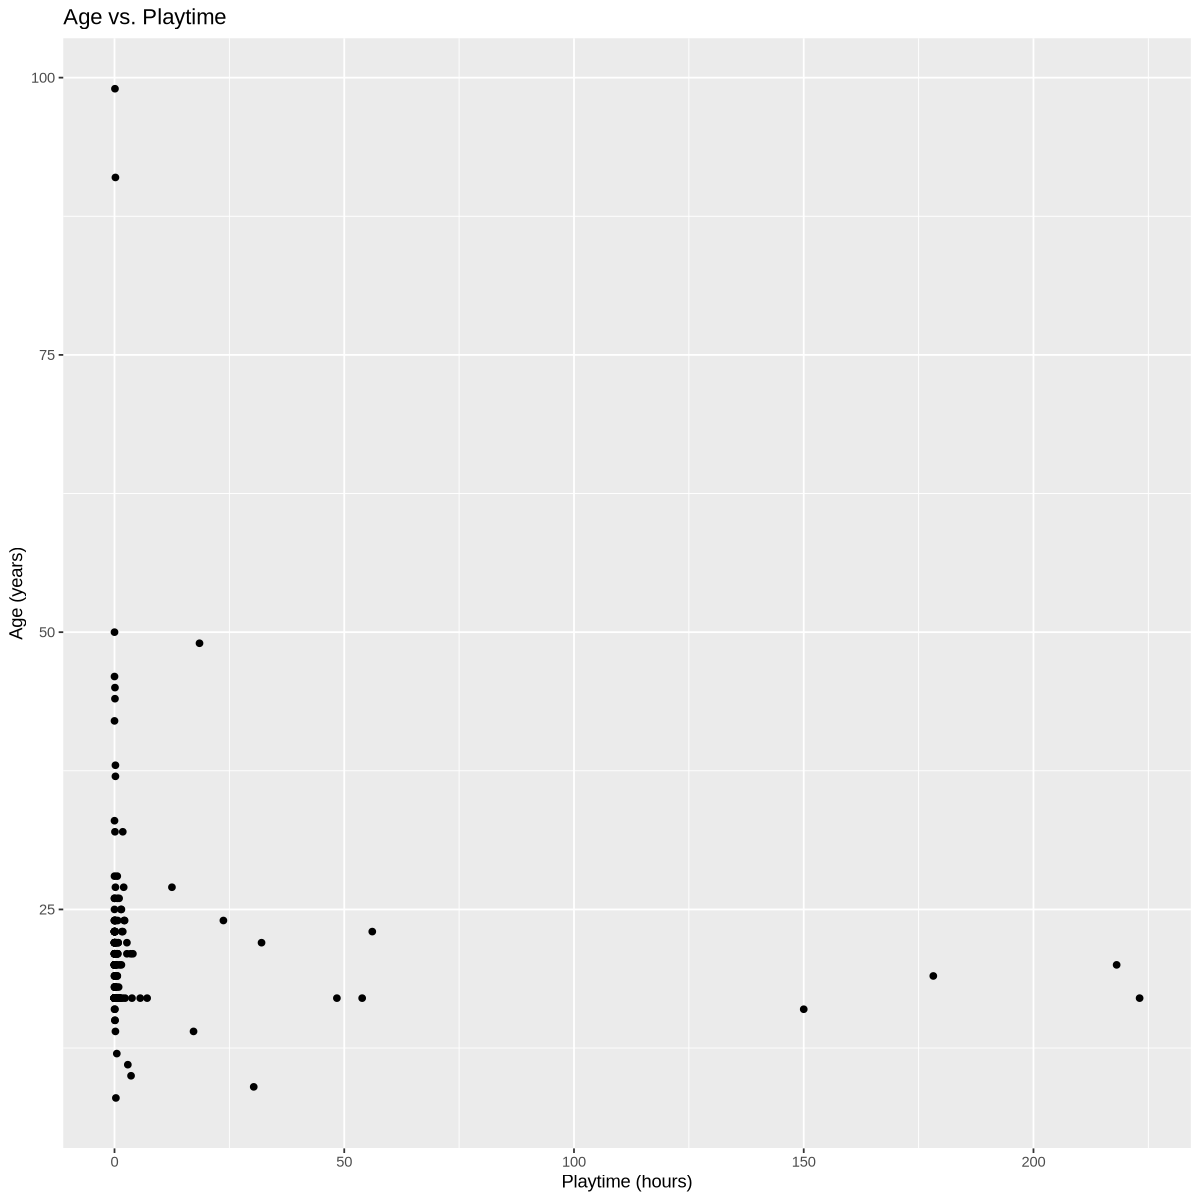

In [47]:
options(repr.plot.width = 10, repr.plot.height = 10)
age_playtime <- data |>
ggplot(aes(x = played_hours, y = age)) +
geom_point() +
labs(x = "Playtime (hours)", y = "Age (years)") +
ggtitle("Age vs. Playtime")
theme(text = element_text(size = 15))

age_playtime

There seem to be a few outliers (e.g. an individual who has played nearly 250 hours alone) and a lot of zero-hour plays, but a **negative relationship** between *age* and *played_hours* is still slightly visible on the scatterplot.

We will now see if that relationship is significant through the linear regression algorithm. In this step, we will:

- create a linear regression model specification, named `lm_spec`
- create a recipe for `lm_spec`, named `data_recipe`
- fit the model specification and recipe in a workflow, named `data_fit`

In [16]:
lm_spec <- linear_reg() |> 
       set_engine("lm") |>
       set_mode("regression")

data_recipe <- recipe(age ~ played_hours, data = data_training)

data_fit <- workflow() |>
       add_recipe(data_recipe) |>
       add_model(lm_spec) |>
       fit(data = data_training)

data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  played_hours  
    21.12587      -0.01092  


The workflow also agrees with us - from the intercept(age) of 21, the average player's playtime **decreases**, at the rate of 0.01092 hours per year.

Next, we will calculate the $RMSE$ to assess the goodness of fit on `data_fit`.

Note that this is going to tell us how well the algorithm predicts the **training data** used to fit the model.

In [19]:
lm_rmse <- data_fit |>
         predict(data_training) |>
         bind_cols(data_training) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmse

[1] 9.045137

The $RMSE$ of 9.045 tells us that the training data points on the scatterplot were off by an average distance of 9.045 years from the line of best fit.

Let's calculate the $RMSPE$ by doing the same process on the **testing data**.

In [20]:
lm_rmspe <- data_fit |>
         predict(data_testing) |>
         bind_cols(data_testing) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

[1] 10.90803

The $RMSPE$ of 10.908 tells us that the training data points on the scatterplot were off by an average distance of 10.908 years from the line of best fit.

That is not satisfactory. Being off by over 10 years on players' age using playtime is telling us our negative relationship is not strong enough to accurately predict either variable.

This may have happened because of the outliers said earlier with surprisingly high age/playtimes.
Let's spot them by ordering the data frame in **descending order** for each variable, using the `arrange` function.

In [21]:
data_age_desc <- arrange(data, desc(age))
data_age_desc

data_playtime_desc <- arrange(data, desc(played_hours))
data_playtime_desc

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,99,1
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,1
Regular,FALSE,7b17513f11968feaf6b02977885c436dc2a4549489ca25ef03022f9fbae19d81,0.0,Balthazar,Male,50,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Regular,TRUE,f2826fb8dbce4d450348f99cb27ade184b713998d9679780442efaaf218038f2,3.6,Zane,Male,10,7
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Regular,TRUE,bc704ff2bc676dbf48ee41b9e11481c1387bf758ad318f2428f336e3fecc6660,0.3,Andy,Male,8,1


experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Regular,TRUE,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,223.1,Hiroshi,Male,17,219
Regular,TRUE,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,218.1,Akio,Non-binary,20,95
Regular,TRUE,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,178.2,Piper,Female,19,147
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0,Rhys,Male,20,NA
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0,Bailey,Female,17,NA
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0,Dylan,Prefer not to say,17,1


We can see that **Devin, Ahmed, Hiroshi, Akio and Piper** have unreasonalby high playtimes or age compared to others, which may be affecting our algorithm's accuracy.

Let's delete them from the data frame using the `fiter` function.

In [22]:
outliers <- c("Devin", "Ahmed", "Hiroshi", "Akio", "Piper")

ref_data <- filter(data, !name %in% outliers)
ref_data

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,1
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,6


Using this refined data frame, we will now repeat the entire process (except creating the recipe, since that is identical) and calculate its $RMSE$ and $RMSPE$.

In [44]:
ref_data_split <- initial_split(ref_data, prop = 0.7, strata = age)
ref_data_training <- training(ref_data_split)
ref_data_testing <- testing(ref_data_split)

ref_data_recipe <- recipe(age ~ played_hours, data = ref_data_training)

ref_data_fit <- workflow() |>
       add_recipe(ref_data_recipe) |>
       add_model(lm_spec) |>
       fit(data = ref_data_training)

In [45]:
ref_lm_rmse <- ref_data_fit |>
         predict(ref_data_training) |>
         bind_cols(ref_data_training) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

ref_lm_rmse

[1] 6.522913

In [46]:
ref_lm_rmspe <- ref_data_fit |>
         predict(ref_data_testing) |>
         bind_cols(ref_data_testing) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

ref_lm_rmspe

[1] 5.367287

NICE! The calculated $RMSE$ and $RMSPE$ values are both signifcantly lower than their previous values. The $RMSPE$ value of 5.367 seems much more accurate!

This tells us that without the outliers, there is a **significantly negative** relationship between `age` and `playtime`.

<h2>Discussion</h2> 

#### Summary of our analysis and findings ####

Based on our exploratory data analysis, we predicted a relationship between the age of the player and the total number of hours played. Based on that intuition, we created a linear regression model, where the predictor variable was the total number of hours played (played_hours) and the predictor variable was the age of the player (age). 

To test the performance of the model, we used the training model to predict age from the test data, and calculated the $RMSPE$. The model had an $RMSPE$ of approximately 5.367. 

Considering the size of the dataset, this $RMSPE$ indicates that **there is a relationship between age and total played hours**. Looking at our plot from figure XXX, we can conclude that **players aged [15,25] are likely to play the game the most, and therefore contribute the greatest volume of data**. 

#### The results aligned with our expectations about the findings ####

The results confirm our intuition, indicating that there exists a relationship between age and total play time. They also connect to our expectations based on day-to-day experiences--we’d expect young adults might be most likely to engage in video games (such as PLAICraft) compared to other age groups. 

#### Impact of the findings #### 

The research team can target people aged [15,25](range around the intercept calculated from REFINED workflow) for their game, since they are likely to play for the greatest total number of hours. These insights can help research team develop PLAIcraft specifically for this target audience. 

The research team could also use this information in their recruitment, in order to develop tailored marketing strategies. If they know that young adult participants are most likely to contribute large amounts of data, they could advertise their study in locations that young adults frequent. 

#### Future questions #### 

Our findings leads to future questions as follows:

* How can the features of the game be improved to cater the game specifically to the target audience? 